In [1]:
# evaluate SIFT/SURF/ORB on test set

# create fraction of number of image plots

# add them to testing pipeline

In [17]:
import os
import sys
sys.path.append('../../')

import pandas as pd

from lightning_data_modules import ImagePairHomographyDataModule
from utils.io import load_yaml



server = 'local'
server = load_yaml('../../config/servers.yml')[server]

configs = load_yaml('../../config/deep_image_homography_estimation_backbone.yml')

# prepare data
prefix = os.path.join(server['database']['location'], configs['data']['pkl_path'])
df = pd.read_pickle(os.path.join(
        prefix,
        configs['data']['pkl_name']
))

rho = 64

# load data module
dm = ImagePairHomographyDataModule(
    df=df,
    prefix=prefix,
    train_split=configs['data']['train_split'],
    random_state=configs['data']['random_state'],
    batch_size=64,
    num_workers=8,
    rho=rho,
    crp_shape=configs['data']['crp_shape'],
    p0=configs['data']['p0'],
    seq_len=configs['data']['seq_len'],
    unsupervised=configs['data']['unsupervised'],
    train_transforms=configs['data']['train_transforms'],
    val_transforms=configs['data']['val_transforms']
)

print('Running with rho of {}'.format(configs['data']['rho']))

dm.setup('test')
test_dl = dm.test_dataloader()

# show df
df[df.test == True]

Running with rho of 32


,folder,file,vid,frame,test
0,test/vid_0,frame_0.npy,0,0,True
1,test/vid_0,frame_1.npy,0,1,True
2,test/vid_0,frame_2.npy,0,2,True
3,test/vid_0,frame_3.npy,0,3,True
4,test/vid_0,frame_4.npy,0,4,True
...,...,...,...,...,...
191302,test/vid_447,frame_1404.npy,447,1404,True
191303,test/vid_447,frame_1405.npy,447,1405,True
191304,test/vid_447,frame_1406.npy,447,1406,True
191305,test/vid_447,frame_1407.npy,447,1407,True


In [10]:
import cv2
import pandas as pd
import numpy as np
from tqdm import tqdm
from kornia import tensor_to_image

from utils.processing import FeatureHomographyEstimation

fd_sift = cv2.SIFT_create()
fh_sift = FeatureHomographyEstimation(fd_sift)

fd_surf = cv2.xfeatures2d.SURF_create()
fh_surf = FeatureHomographyEstimation(fd_surf)

fd_orb = cv2.ORB_create()
fh_orb = FeatureHomographyEstimation(fd_orb)

fhs = {
    'SIFT': fh_sift, 
    'SURF': fh_surf, 
    'ORB': fh_orb
}

log_df_sift = pd.DataFrame(columns=['duv', 'duv_pred', 'duv_mpd'])
log_df_surf = pd.DataFrame(columns=['duv', 'duv_pred', 'duv_mpd'])
log_df_orb  = pd.DataFrame(columns=['duv', 'duv_pred', 'duv_mpd'])

log_dfs = {
    'SIFT': log_df_sift,
    'SURF': log_df_surf, 
    'ORB': log_df_orb
}

for batch in tqdm(test_dl):
    img, wrp, duv = batch['img_crp'], batch['wrp_crp'], batch['duv']
    img, wrp = tensor_to_image(img), tensor_to_image(wrp)
    img, wrp = (img*255).astype(np.uint8), (wrp*255).astype(np.uint8)

    duv = duv.squeeze().numpy()

    for key in fhs:
        H_pred, duv_pred = fhs[key](img, wrp)

        if H_pred is None:
            duv_mpd = np.nan
        else:
            duv_mpd = np.linalg.norm(duv - duv_pred, axis=1).mean()

        log_dfs[key] = log_dfs[key].append({
            'duv': duv,
            'duv_pred': duv_pred,
            'duv_mpd': duv_mpd
        }, ignore_index=True)

for key in log_dfs:
    log_dfs[key].to_pickle('{}_ft_rho_{}_duv.pkl'.format(key, configs['data']['rho']))

100%|██████████| 33835/33835 [50:46<00:00, 11.10it/s]


In [18]:
# load model
# run through data

import torch
from tqdm import tqdm
import numpy as np
import time
from utils.io import generate_path

from lightning_modules import DeepImageHomographyEstimationModuleBackbone


# load model
# prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai/regnet_y/1_6_gf/version_0'
prefix = '/home/martin/Tresors/homography_imitation_learning_logs/ae_cai'
rho_32_models = [
    # VGG
    'vgg',

    # ResNet
    'resnet/18',
    'resnet/34',
    'resnet/50',

    # EfficientNet
    'efficient_net/b0',
    'efficient_net/b1',
    'efficient_net/b2',
    'efficient_net/b3',
    'efficient_net/b4',
    'efficient_net/b5',

    # RegNetY
    'regnet_y/400_mf',
    'regnet_y/600_mf',
    'regnet_y/800_mf',
    'regnet_y/1_6_gf',
    'regnet_y/4_0_gf',
    'regnet_y/6_4_gf'
]

rho_64_models = [
    # VGG
    'vgg/64',

    # ResNet
    'resnet/64/18',
    'resnet/64/34',
    'resnet/64/50',

    # EfficientNet
    'efficient_net/64/b0',
    'efficient_net/64/b1',
    'efficient_net/64/b2',
    'efficient_net/64/b3',
    'efficient_net/64/b4',
    'efficient_net/64/b5',

    # RegNetY
    'regnet_y/64/400_mf',
    'regnet_y/64/600_mf',
    'regnet_y/64/800_mf',
    'regnet_y/64/1_6_gf',
    'regnet_y/64/4_0_gf',
    'regnet_y/64/6_4_gf'
]

for model_path in rho_64_models:
    print('Testing {}'.format(model_path))

    configs = load_yaml(os.path.join(prefix, model_path, 'version_0', 'config.yml'))
    model = DeepImageHomographyEstimationModuleBackbone.load_from_checkpoint(os.path.join(prefix, model_path, 'version_0', 'checkpoints/epoch=49-step=94349.ckpt'), shape=configs['model']['shape'])

    device = 'cpu'
    if torch.cuda.is_available():
        print('Running with CUDA backend.')
        device = 'cuda'

    model.to(device)
    model = model.eval()
    model.freeze()

    log_df = pd.DataFrame(columns=['duv', 'duv_pred', 'duv_mpd', 'batch_dt'])

    for batch in tqdm(test_dl):
        batch = dm.transfer_batch_to_device(batch, device)
        imgs, wrps, duvs = batch['img_crp'], batch['wrp_crp'], batch['duv']

        start = time.time()
        duvs_pred = model(imgs, wrps)
        dt = time.time() - start
        
        for duv, duv_pred in zip(duvs, duvs_pred):
            duv, duv_pred = duv.squeeze().cpu().numpy(), duv_pred.squeeze().cpu().numpy()
            duv_mpd = np.linalg.norm(duv - duv_pred, axis=1).mean()

            log_df = log_df.append({
                'duv': duv,
                'duv_pred': duv_pred,
                'duv_mpd': duv_mpd,
                'batch_dt': dt
            }, ignore_index=True)


    category = model_path.split('/')[-0]
    export = model_path.split('/')[-1]
    output_path = 'rho_{}/{}'.format(rho, category)
    generate_path(output_path)
    log_df.to_pickle('{}/{}_duv.pkl'.format(output_path, export))
    

Testing vgg/64


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [04:24<00:00,  2.00it/s]


Testing resnet/64/18


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:35<00:00,  2.45it/s]


Testing resnet/64/34


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:56<00:00,  2.24it/s]


Testing resnet/64/50


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [04:34<00:00,  1.93it/s]


Testing efficient_net/64/b0


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:55<00:00,  2.25it/s]


Testing efficient_net/64/b1


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [04:07<00:00,  2.14it/s]


Testing efficient_net/64/b2


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [04:24<00:00,  2.00it/s]


Testing efficient_net/64/b3


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [04:38<00:00,  1.90it/s]


Testing efficient_net/64/b4


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [05:02<00:00,  1.75it/s]


Testing efficient_net/64/b5


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [06:12<00:00,  1.42it/s]


Testing regnet_y/64/400_mf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:39<00:00,  2.41it/s]


Testing regnet_y/64/600_mf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:51<00:00,  2.28it/s]


Testing regnet_y/64/800_mf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [03:47<00:00,  2.32it/s]


Testing regnet_y/64/1_6_gf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [07:39<00:00,  1.15it/s]


Testing regnet_y/64/4_0_gf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [07:18<00:00,  1.21it/s]


Testing regnet_y/64/6_4_gf


  0%|          | 0/529 [00:00<?, ?it/s]

Running with CUDA backend.


100%|██████████| 529/529 [10:41<00:00,  1.21s/it]


Computing CDF for ft/SIFT
ft/SIFT - 14.23 +/- 247.49
Computing CDF for ft/SURF
ft/SURF - 12.14 +/- 227.85
Computing CDF for ft/ORB
ft/ORB - 83.71 +/- 1289.21
Computing CDF for vgg/vgg
vgg/vgg - 7.48 +/- 4.17, execution time 3.36 +/- 13.06
Computing CDF for resnet/18
resnet/18 - 2.61 +/- 2.08, execution time 7.00 +/- 5.46
Computing CDF for resnet/34
resnet/34 - 2.40 +/- 1.92, execution time 10.16 +/- 4.97
Computing CDF for resnet/50
resnet/50 - 2.51 +/- 2.03, execution time 18.31 +/- 4.71
Computing CDF for efficient_net/b0
efficient_net/b0 - 2.44 +/- 1.95, execution time 26.64 +/- 10.03
Computing CDF for efficient_net/b1
efficient_net/b1 - 2.34 +/- 1.90, execution time 31.91 +/- 8.98
Computing CDF for efficient_net/b2
efficient_net/b2 - 2.39 +/- 1.86, execution time 27.83 +/- 8.87
Computing CDF for efficient_net/b3
efficient_net/b3 - 2.28 +/- 1.86, execution time 25.12 +/- 6.26
Computing CDF for efficient_net/b4
efficient_net/b4 - 2.16 +/- 1.82, execution time 36.88 +/- 6.48
Computing C

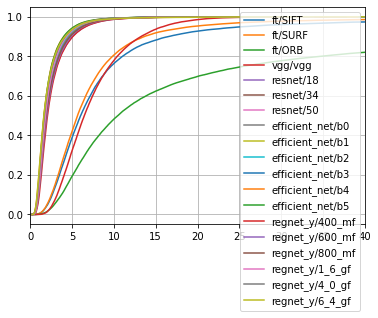

In [1]:
import pandas as pd
import matplotlib.pyplot as plt


stats_dfs = []
eval_df = pd.DataFrame(columns=['parameters', 'th30', 'th50', 'th70', 'th90'])

rho = 32
fds = [
    'ft/SIFT', 'ft/SURF', 'ft/ORB', 
    'vgg/vgg',
    'resnet/18', 'resnet/34', 'resnet/50',
    'efficient_net/b0','efficient_net/b1','efficient_net/b2','efficient_net/b3','efficient_net/b4','efficient_net/b5',
    'regnet_y/400_mf','regnet_y/600_mf','regnet_y/800_mf','regnet_y/1_6_gf','regnet_y/4_0_gf','regnet_y/6_4_gf'
]

parameters = {
    'ft/SIFT': 0, 'ft/SURF': 0, 'ft/ORB': 0, 
    'vgg/vgg': 92916360,
    'resnet/18': 11689512, 'resnet/34': 21797672, 'resnet/50': 25557032,
    'efficient_net/b0': 5288548, 'efficient_net/b1': 7794184,'efficient_net/b2': 9109994,'efficient_net/b3': 12233232, 'efficient_net/b4': 19341616,'efficient_net/b5': 30389784,
    'regnet_y/400_mf': 4344144, 'regnet_y/600_mf': 6055160, 'regnet_y/800_mf': 6263168, 'regnet_y/1_6_gf': 11202430, 'regnet_y/4_0_gf': 20646656, 'regnet_y/6_4_gf': 30583252

}

duv_means = {}
duv_stds = {}


for fd in fds:
    print('Computing CDF for {}'.format(fd))
    duv_df = pd.read_pickle('rho_{}/{}_duv.pkl'.format(rho, fd))
    stats_df = duv_df.groupby('duv_mpd')['duv_mpd'].agg('count').pipe(pd.DataFrame).rename(columns = {'duv_mpd': 'frequency'})

    # PDF
    stats_df['pdf'] = stats_df['frequency'] / sum(stats_df['frequency'])

    # CDF
    stats_df['cdf'] = stats_df['pdf'].cumsum()
    stats_df = stats_df.reset_index()
    stats_dfs.append(stats_df)

    th30 = stats_df[stats_df.cdf < 0.3].iloc[-1]
    th50 = stats_df[stats_df.cdf < 0.5].iloc[-1]
    th70 = stats_df[stats_df.cdf < 0.7].iloc[-1]
    th90 = stats_df[stats_df.cdf < 0.9].iloc[-1]
    eval_df = eval_df.append({
        'parameters': parameters[fd],
        'th30': th30.duv_mpd,
        'th50': th50.duv_mpd,
        'th70': th70.duv_mpd,
        'th90': th90.duv_mpd
    }, ignore_index=True)

    duv_mean, duv_std = duv_df.duv_mpd.mean(), duv_df.duv_mpd.std()
    duv_means[fd], duv_stds[fd] = duv_mean, duv_std

    if not fd in fds[:3]:
        print('{} - {:.2f} +/- {:.2f}, execution time {:.2f} +/- {:.2f}'.format(fd, duv_mean, duv_std, duv_df.batch_dt.mean()*1.e3, duv_df.batch_dt.std()*1.e3))
    else:
        print('{} - {:.2f} +/- {:.2f}'.format(fd, duv_mean, duv_std))

for stats_df, fd in zip(stats_dfs, fds):

    plt.plot(stats_df['duv_mpd'], stats_df['cdf'], label=fd)
    plt.grid()
    plt.legend()
    plt.xlim([0, 40])

# plt.show()
plt.savefig('/media/martin/Samsung_T5/03_07_21_ae_cai_measurements/fig/frac/rho_32.pdf')

In [2]:
eval_df

,parameters,th30,th50,th70,th90
0,0.0,4.276555,6.024077,8.653774,16.518100
1,0.0,4.063654,5.648234,7.925365,13.624305
2,0.0,6.520230,10.475262,20.117138,122.661466
3,92916360.0,4.828714,6.465382,8.682452,13.234516
4,11689512.0,1.424146,1.952301,2.819191,5.057985
5,21797672.0,1.331774,1.806116,2.562447,4.626608
6,25557032.0,1.395187,1.893797,2.696126,4.792773
7,5288548.0,1.363279,1.830671,2.616789,4.643602
8,7794184.0,1.320256,1.771797,2.504267,4.422697
9,9109994.0,1.396699,1.850959,2.574481,4.424207


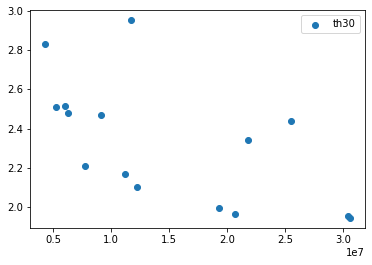

In [3]:
import matplotlib.pyplot as plt

plt.scatter(eval_df.parameters[4:], eval_df.th30[4:], label='th30')
plt.scatter(eval_df.parameters[4:], eval_df.th50[4:], label='th50')
plt.scatter(eval_df.parameters[4:], eval_df.th70[4:], label='th70')
# plt.scatter(eval_df.parameters, eval_df.th90, label='th90')
plt.legend()
plt.show()

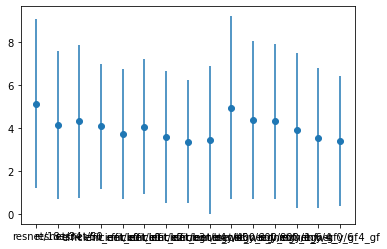

In [21]:
import matplotlib.pyplot as plt

# plt.scatter(list(duv_means.keys())[4:], list(duv_means.values())[4:])
plt.errorbar(list(duv_means.keys())[4:], list(duv_means.values())[4:], yerr=list(duv_stds.values())[4:], fmt='o')
plt.show()

# Forward Backward Consistency